**Table of contents**<a id='toc0_'></a>    
- [Delta Live Tables metaprogramming with Python example](#toc1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Delta Live Tables metaprogramming with Python example](#toc0_)

In [ ]:
import dlt
from pyspark.sql.functions import *

def create_table(name):
  @dlt.table(name=name)
  def t():
    return spark.read.table(name)

In [ ]:
import dlt
from pyspark.sql.functions import *

@dlt.table(
  name="raw_fire_department",
  comment="raw table for fire department response"
)
@dlt.expect_or_drop("valid_received", "received IS NOT NULL")
@dlt.expect_or_drop("valid_response", "responded IS NOT NULL")
@dlt.expect_or_drop("valid_neighborhood", "neighborhood != 'None'")
def get_raw_fire_department():
  return (
    spark.read.format('csv')
      .option('header', 'true')
      .option('multiline', 'true')
      .load('/databricks-datasets/timeseries/Fires/Fire_Department_Calls_for_Service.csv')
      .withColumnRenamed('Call Type', 'call_type')
      .withColumnRenamed('Received DtTm', 'received')
      .withColumnRenamed('Response DtTm', 'responded')
      .withColumnRenamed('Neighborhooods - Analysis Boundaries', 'neighborhood')
    .select('call_type', 'received', 'responded', 'neighborhood')
  )

all_tables = []

def generate_tables(call_table, response_table, filter):
  @dlt.table(
    name=call_table,
    comment="top level tables by call type"
  )
  def create_call_table():
    return (
      spark.sql("""
        SELECT
          unix_timestamp(received,'M/d/yyyy h:m:s a') as ts_received,
          unix_timestamp(responded,'M/d/yyyy h:m:s a') as ts_responded,
          neighborhood
        FROM LIVE.raw_fire_department
        WHERE call_type = '{filter}'
      """.format(filter=filter))
    )

  @dlt.table(
    name=response_table,
    comment="top 10 neighborhoods with fastest response time "
  )
  def create_response_table():
    return (
      spark.sql("""
        SELECT
          neighborhood,
          AVG((ts_received - ts_responded)) as response_time
        FROM LIVE.{call_table}
        GROUP BY 1
        ORDER BY response_time
        LIMIT 10
      """.format(call_table=call_table))
    )

  all_tables.append(response_table)

generate_tables("alarms_table", "alarms_response", "Alarms")
generate_tables("fire_table", "fire_response", "Structure Fire")
generate_tables("medical_table", "medical_response", "Medical Incident")

@dlt.table(
  name="best_neighborhoods",
  comment="which neighbor appears in the best response time list the most"
)
def summary():
  target_tables = [dlt.read(t) for t in all_tables]
  unioned = functools.reduce(lambda x,y: x.union(y), target_tables)
  return (
    unioned.groupBy(col("neighborhood"))
      .agg(count("*").alias("score"))
      .orderBy(desc("score"))
  )


Name,Type
neighborhood,string
score,bigint


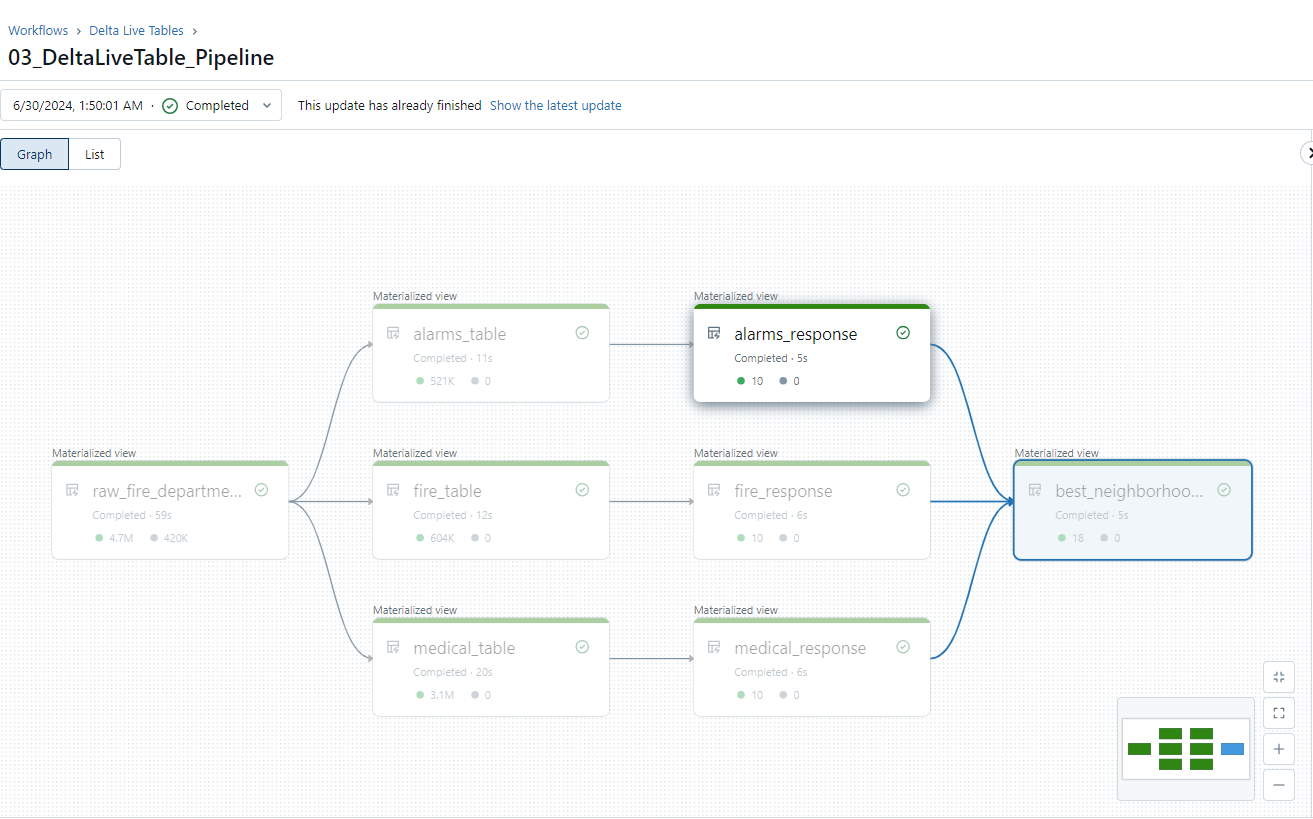

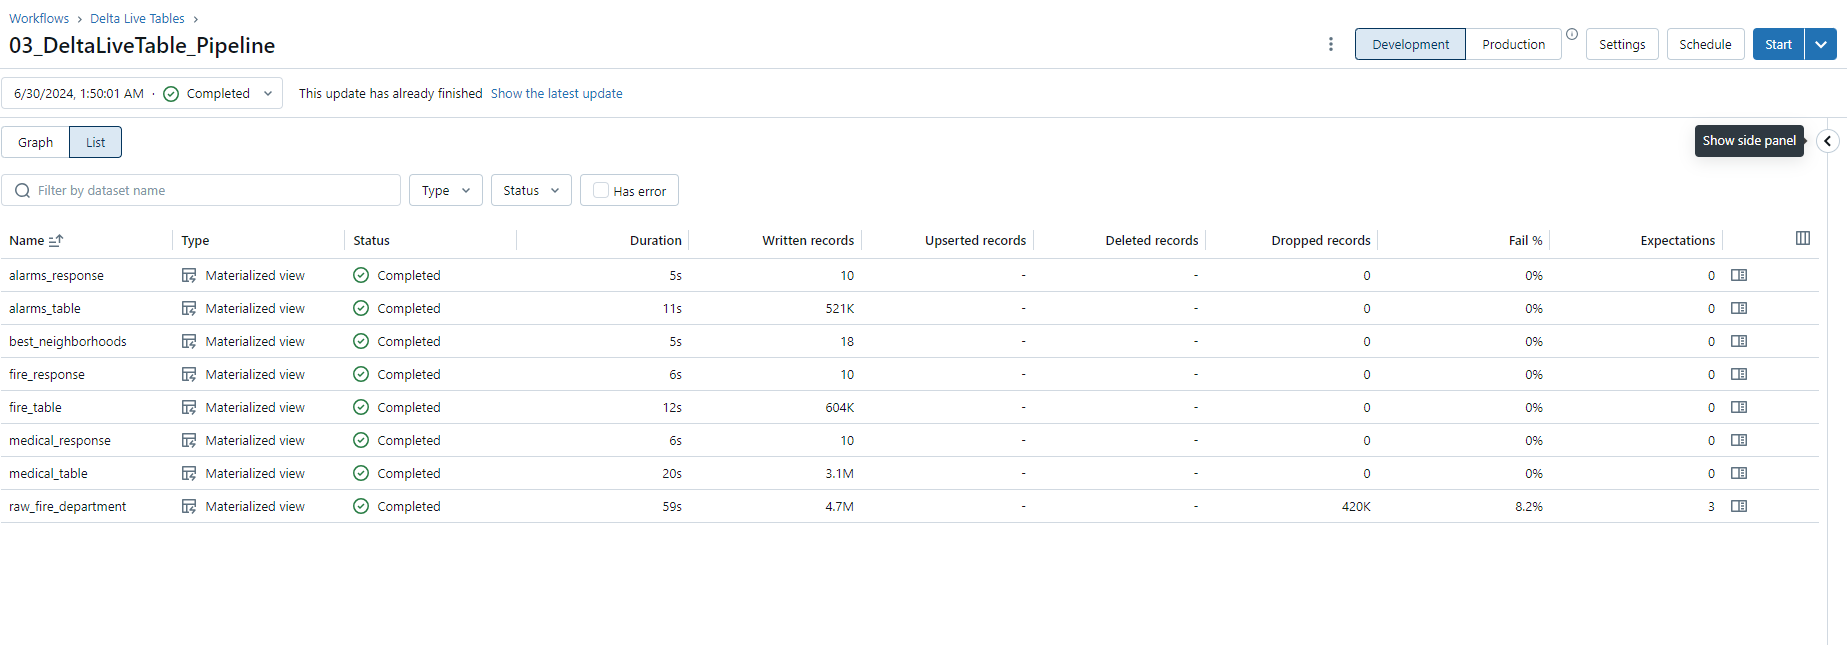

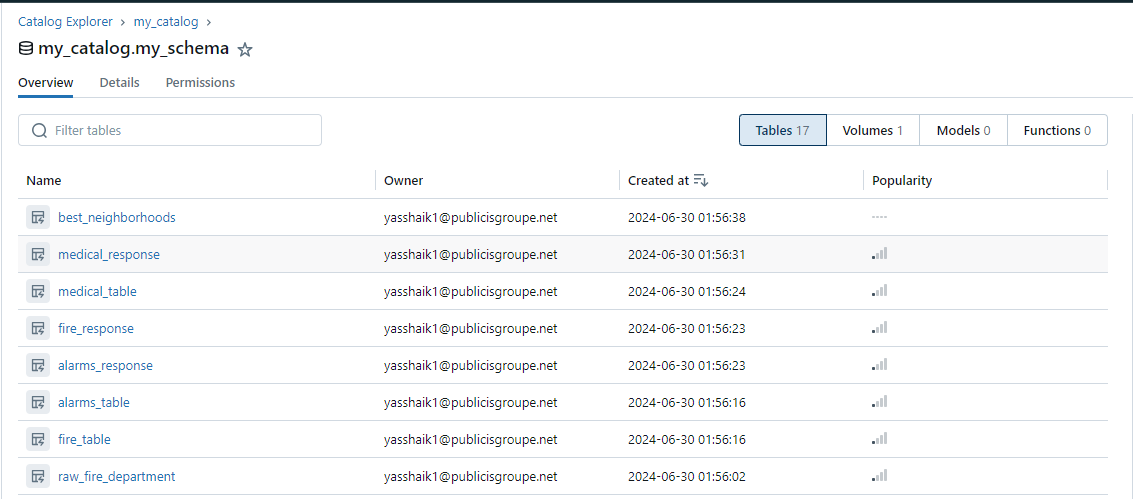

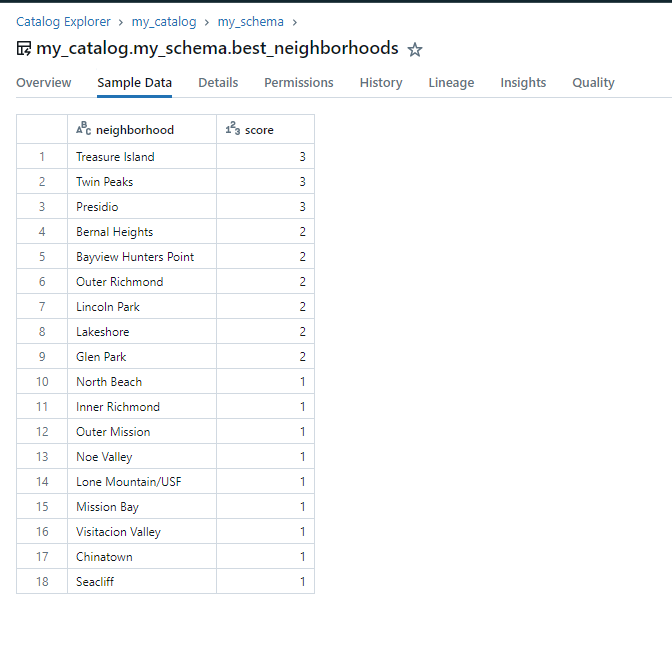